In [1]:
import json
import os
import math
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras as keras
from keras.regularizers import l2
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = "C://Users//miran//.vscode//musicClassification//Data//genres_original"
JSON_PATH = "data_maps.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

# Data preprocessing and labeling

In [3]:
def get_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, blocksize=512, num_segments=5):
   # dictionary to store mapping, labels, and MFCCs
    data_map = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / blocksize)

    for i, (root, dirs, files) in enumerate(os.walk(dataset_path)):

      if root is dataset_path:
        continue

      # get genres of music
      genre_label = root.split("\\")[-1]
      data_map["mapping"].append(genre_label)
      
      for file in files:

        file_path = os.path.join(root, file)
        audio_signal, sf = librosa.load(file_path, sr=SAMPLE_RATE)
        
        for seg in range(num_segments):
          start_seg = samples_per_segment * seg
          end_seg = start_seg + samples_per_segment

          mfcc = librosa.feature.mfcc(y=audio_signal[start_seg:end_seg], sr=sf, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=blocksize)
          mfcc = mfcc.T

          if len(mfcc) == num_mfcc_vectors_per_segment:
                data_map["mfcc"].append(mfcc.tolist())
                data_map["labels"].append(i-1)
                print("{}, segment:{}".format(file_path, seg+1))

    # save mfcc to json
    with open(json_path, "w") as fp:
      json.dump(data_map, fp, indent=4)


In [4]:
get_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:1
C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:2
C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:3
C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:4
C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:5
C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:6
C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:7
C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:8
C://Users//miran//.vscode//musicClassification//Data//genres_original\blues\blues.00000.wav, segment:9
C://Users//miran//.vscode//musicClassification//Data//genres_original\blu

# Implementing NN

In [20]:
def load_data(json_path):
  with open(json_path, "r") as fp:
    data = json.load(fp)

  # convert lists to numpy arrays
  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs, targets

In [25]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.1355 - loss: 40.0383 - val_accuracy: 0.2423 - val_loss: 3.5473
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1696 - loss: 7.1894 - val_accuracy: 0.1405 - val_loss: 3.4806
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1382 - loss: 4.7464 - val_accuracy: 0.1175 - val_loss: 3.4878
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1296 - loss: 3.9518 - val_accuracy: 0.1101 - val_loss: 3.4918
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1260 - loss: 3.7769 - val_accuracy: 0.1162 - val_loss: 3.4848
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1295 - loss: 3.6925 - val_accuracy: 0.1282 - val_loss: 3.4650
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1505 - loss: 3.5636 - val_accuracy: 0.1502 - val_loss: 3.4297
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1494 - loss: 3.5203 - val_a

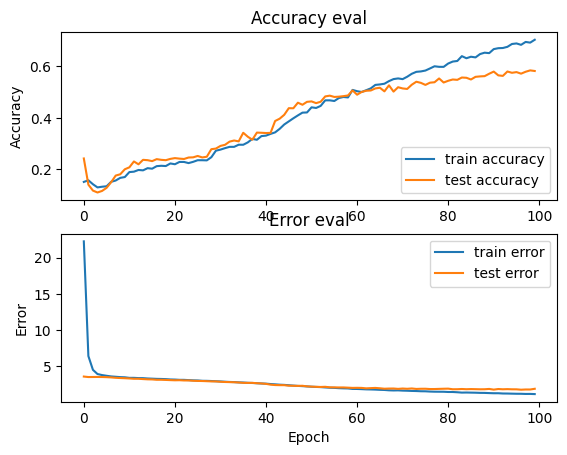

In [31]:
X, Y = load_data(JSON_PATH)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

dropout_rate = 0.3
l2_reg_factor = 0.001
# build network, sequential model where there is 1 tensor flowing in and 1 tensor flowing out
model = keras.Sequential([
  keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(l2_reg_factor)),  # Added L2 regularization
  keras.layers.Dropout(dropout_rate),  # Added Dropout
  keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(l2_reg_factor)),  # Added L2 regularization
  keras.layers.Dropout(dropout_rate),  # Added Dropout
  keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(l2_reg_factor)),  # Added L2 regularization
  keras.layers.Dropout(dropout_rate),  # Added Dropout
  keras.layers.Dense(10, activation='softmax')
])

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=100)

plot_history(history)

## CNN Model

In [36]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    """

    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to represent the channel of audio
    X_train = X_train[..., np.newaxis] # 4d array -> (num_samples, 130, 13, 1), 130 is the number of segments and 13 is the number of mfccs
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [37]:
def generate_model(input_shape):
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [38]:
def predict(model, X, y):
    X = X[np.newaxis, ...]
    prediction = model.predict(X)

    predicted_index = np.argmax(prediction, axis=1)
    print("Expected index: {}, Predicted index: {}".format(y, predicted_index))


c:\Users\miran\.vscode\musicClassification\venv-music\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1631 - loss: 2.8457 - val_accuracy: 0.3545 - val_loss: 1.8747
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3047 - loss: 2.0187 - val_accuracy: 0.4499 - val_loss: 1.5613
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3818 - loss: 1.7608 - val_accuracy: 0.4993 - val_loss: 1.3858
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4237 - loss: 1.6237 - val_accuracy: 0.5327 - val_loss: 1.2722
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4664 - loss: 1.4999 - val_accuracy: 0.5534 - val_loss: 1.1957
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4974 - loss: 1.4175 - val_accuracy: 0.5808 - val_loss: 1.1376
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5254 - loss: 1.3413 - val_accuracy: 0.5988 - val_loss: 1.1097
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5402 - loss: 1.2883 - val_accu

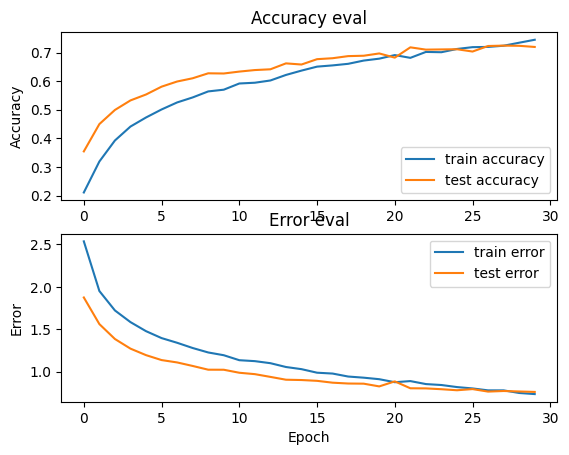

79/79 - 0s - 4ms/step - accuracy: 0.7076 - loss: 0.8469

Test accuracy: 0.7076491713523865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Expected index: 0, Predicted index: [0]


In [39]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = generate_model(input_shape)

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)